## Task 3
### Solving ordinary differential equations of the second order by projectrive methods

In [735]:
from math import sin
from typing import Callable, Tuple

import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy import integrate
from scipy.sparse import lil_matrix
from scipy.special import jacobi
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev as cheb

In [736]:
Function = Callable[[float], float]
BoundaryValue = Tuple[float, float, float]
CoordinateSystem = list[Polynomial]
Grid = Tuple[np.ndarray, float]

In [737]:
def get_jacobi(n: int, k: int) -> CoordinateSystem:
    return [jacobi(i, k, k) for i in range(n)]

### Ritz method
Solves equation $ Ly = -(p(x)y')' + r(x)y = f(x) $

In [738]:
def ritz_method(
        p: Function,
        q: Function,
        r: Function,
        f: Function,
        left_boundary_value: BoundaryValue,
        right_boundary_value: BoundaryValue,
        n: int) -> Function:
    coordinates = get_jacobi(n, 1)
    matrix = np.zeros((n, n))
    right_part = np.zeros(n)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            matrix[i, j] = bilinear_form(coordinates[i], coordinates[j], p, r, left_boundary_value, right_boundary_value)
        right_part[i] = dot(coordinates[i], f)

    coeffs = np.linalg.solve(matrix, right_part)
    return lambda x: sum(coeffs[i] * coordinates[i](x) for i in range(n))

def bilinear_form(
        y: Polynomial,
        z: Polynomial,
        p: Function,
        r: Function,
        left_boundary_value: BoundaryValue,
        right_boundary_value: BoundaryValue) -> float:
    alpha_1, alpha_2, _ = left_boundary_value
    beta_1, beta_2, _ = right_boundary_value
    result = integrate.quad(lambda x: p(x) * y.deriv()(x) * z.deriv()(x) + r(x) * y(x) * z(x), -1, 1)[0]
    q_l = 0 if alpha_1 * alpha_2 == 0 else alpha_1 / alpha_2 * p(-1) * y(-1) * z(-1)
    q_r = 0 if beta_1 * beta_2 == 0 else beta_1 / beta_2 * p(1) * y(1) * z(1)
    result += q_l
    result += q_r
    return result

def dot(phi: Function, f: Function) -> float:
    return integrate.quad(lambda x: f(x) * phi(x), -1, 1)[0]

In [739]:
def collocation_method(
        p: Function,
        q: Function,
        r: Function,
        f: Function,
        left_boundary_value: BoundaryValue,
        right_boundary_value: BoundaryValue,
        n: int) -> Function:
    coordinates = get_coordinate_system(left_boundary_value, right_boundary_value, n)

    nodes = cheb.chebroots(np.append(np.zeros(n), 1))
    matrix = np.zeros((n, n))
    b = np.zeros(n)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            matrix[i, j] = Lphi(coordinates[j], p, q, r)(nodes[i])
        b[i] = f(nodes[i])

    coeffs = np.linalg.solve(matrix, b)
    return lambda x: sum(coeffs[i] * coordinates[i](x) for i in range(n))

def Lphi(phi: Polynomial, p: Function, q: Function, r: Function) -> Function:
    return lambda x: p(x) * phi.deriv(2)(x) + q(x) * phi.deriv()(x) + r(x) * phi(x)

def get_coordinate_system(
        left_boundary_value: BoundaryValue,
        right_boundary_value: BoundaryValue,
        n: int) -> CoordinateSystem:
    system = []

    alpha_1, alpha_2, _ = left_boundary_value
    beta_1, beta_2, _ = right_boundary_value
    
    if n >= 1:
        matrix = [[-(alpha_1 + alpha_2), alpha_1],
                    [beta_1 + beta_2, beta_1]]
        b = [-(alpha_1 + 2 * alpha_2),
                -(beta_1 + 2 * beta_2)]
        coeffs = np.append(list(reversed(np.linalg.solve(matrix, b))), 1)
        system.append(Polynomial(coeffs))

    if n >= 2:
        matrix = [[-(alpha_1 + alpha_2), alpha_1],
                    [beta_1 + beta_2, beta_1]]
        b = [alpha_1 + 3 * alpha_2,
                -(beta_1 + 3 * beta_2)]
        coeffs = np.append(list(reversed(np.linalg.solve(matrix, b))), [0, 1])
        system.append(Polynomial(coeffs))

    if n >= 3:
        jacobi_coeff = Polynomial([1, 0, -1]) ** 2
        system += [jacobi_coeff * j for j in get_jacobi(n - 2, 2)]

    return system

In [740]:
def solve_tridiagonal_system(matrix: lil_matrix, b: np.ndarray) -> np.ndarray:
    s = np.zeros(b.size)
    t = np.zeros(b.size)
    A, B, C, G = np.insert(matrix.diagonal(-1), 0, 0), -matrix.diagonal(), np.append(matrix.diagonal(1), 0), b

    for i in range(b.size):
        s[i] = C[i] / (B[i] - A[i] * s[i - 1])
        t[i] = (A[i] * t[i - 1] - G[i]) / (B[i] - A[i] * s[i - 1])
    
    y = np.zeros(b.size)
    y[-1] = t[-1]

    for i in reversed(range(b.size - 1)):
        y[i] = s[i] * y[i + 1] + t[i]

    return y


def solve_equation(
        a: float,
        b: float,
        p: Function,
        q: Function,
        r: Function,
        f: Function,
        left_condition: BoundaryValue,
        right_condition: BoundaryValue,
        N: int) -> Tuple[np.ndarray, np.ndarray]:
    size = N + 1
    points, h = np.linspace(a, b, size, retstep=True)

    matrix = lil_matrix((size, size))
    b = np.zeros(size)

    for i in range(1, N):
        x_i = points[i]
        matrix[i, i - 1] = -p(x_i) / (h ** 2) - q(x_i) / (2 * h)
        matrix[i, i] = p(x_i) * 2 / (h ** 2) + r(x_i)
        matrix[i, i + 1] = -p(x_i) / (h ** 2) + q(x_i) / (2 * h)
        b[i] = f(x_i)

    alpha_1, alpha_2, alpha = left_condition
    beta_1, beta_2, beta = right_condition

    matrix[0, :3] = alpha_1 - alpha_2 * ((-3 / 2) / h), -alpha_2 * (2 / h), -alpha_2 * ((-1 / 2) / h)
    b[0] = alpha

    matrix[N, N - 2:] = beta_2 * ((1 / 2) / h), beta_2 * (-2 / h), beta_1 + beta_2 * ((3 / 2) / h)
    b[N] = beta

    coefficient_0, coefficient_N = matrix[0, 2] / matrix[1, 2], matrix[N, N - 2] / matrix[N - 1, N - 2]
    matrix[0] -= coefficient_0 * matrix[1]
    matrix[N] -= coefficient_N * matrix[N - 1]
    b[0] -= coefficient_0 * b[1]
    b[N] -= coefficient_N * b[N - 1]

    return points, solve_tridiagonal_system(matrix, b)


def solve_with_accuracy(
        a: float,
        b: float,
        p: Function,
        q: Function,
        r: Function,
        f: Function,
        left_condition: BoundaryValue,
        right_condition: BoundaryValue,
        accuracy: float,
        start_n: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    n = start_n
    grid_errors = []

    _, previous_solution = solve_equation(a, b, p, q, r, f, left_condition, right_condition, n)
    while True:
        n *= 2
        points, current_solution = solve_equation(a, b, p, q, r, f, left_condition, right_condition, n)
        
        errors = np.zeros(current_solution.size)
        for i in range(0, errors.size, 2):
            errors[i] = (current_solution[i] - previous_solution[i // 2]) / 3
        for i in range(1, errors.size - 1, 2):
            errors[i] = (errors[i - 1] + errors[i + 1]) / 2

        error = max(abs(errors))
        grid_errors.append((n, error))

        current_solution += errors
        if error < accuracy:
            break

        previous_solution = current_solution
    return points, current_solution, np.array(grid_errors)

In [741]:
def get_true_error_norm(true_solution: np.ndarray, actual_solution: np.ndarray) -> float:
    return abs(true_solution - actual_solution).max()

def generate_colors(num_colors):
    # Create an array of equally spaced values from 0 to 1
    interpolation_values = np.linspace(0, 1, num_colors)

    # Generate RGB values from blue to red
    colors = np.zeros((num_colors, 3))
    colors[:, 0] = 1 - interpolation_values  # Red component
    colors[:, 2] = interpolation_values       # Blue component

    return colors

def run_test(a, b, p, q, r, f, left_boundary_value, right_boundary_value, solve_function, low_n=2, high_n=12):
    colors = generate_colors(int((high_n - low_n) / 2))[::-1]

    plt.figure(figsize=(10, 5))
    grid_points, grid_solution, _ = solve_with_accuracy(a, b, p, q, r, f, left_boundary_value, right_boundary_value, 10 ** -6)

    errors = []
    grid_sizes = []

    for i, n in enumerate(range(low_n, high_n, 2)):
        result = solve_function(p, q, r, f, left_boundary_value, right_boundary_value, n)
        values = []
        for point in grid_points:
            values.append(result(point))
        
        error = get_true_error_norm(np.array(grid_solution), np.array(values))

        errors.append(error)
        grid_sizes.append(n)

        plt.plot(grid_points, values, label=f'n = {n}', color=colors[i])

    plt.plot(grid_points, grid_solution, label=f'grid method', color='green')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.title('Result')
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(grid_sizes, errors, label='Errors', color='red')
    plt.yscale('log')
    plt.xlabel('N')
    plt.ylabel('error norm')
    plt.grid()
    plt.title('Errors')
    plt.show()

### Test

Results for Ritz method:


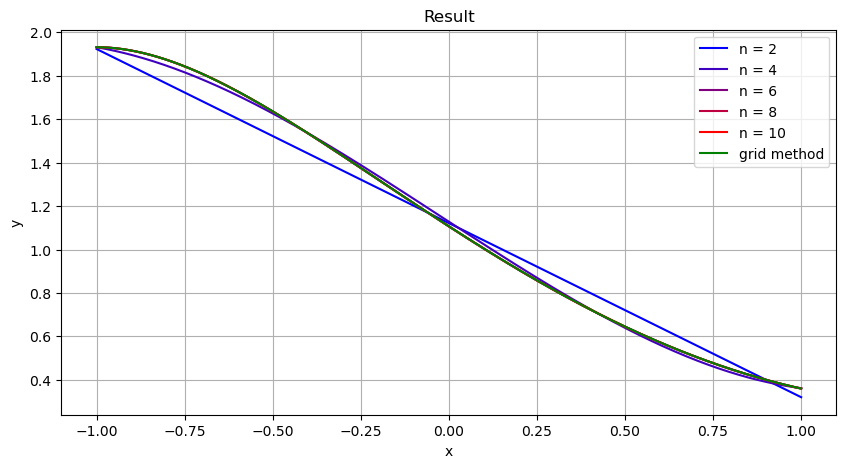

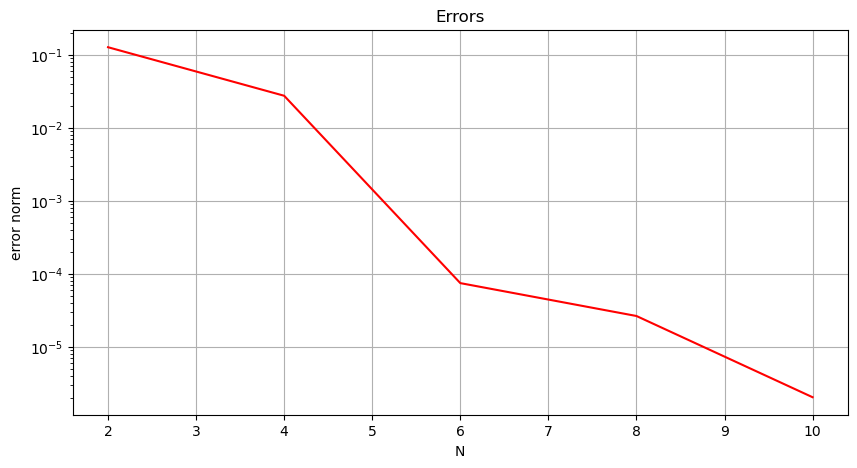

Results for Collacation method:


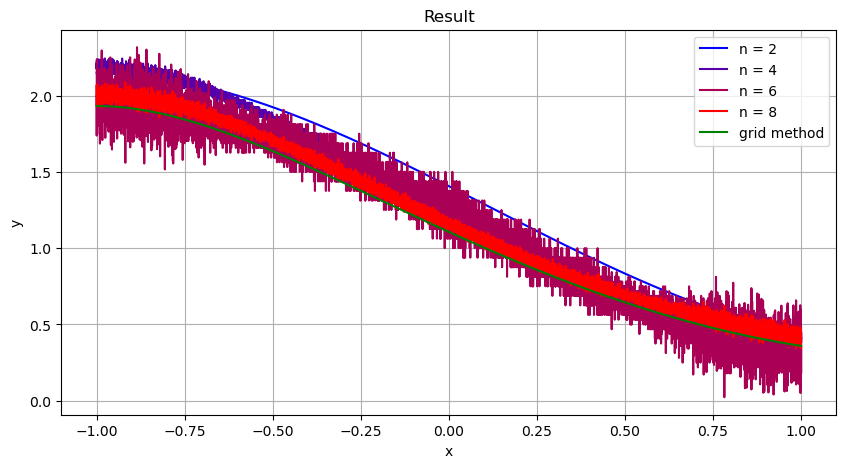

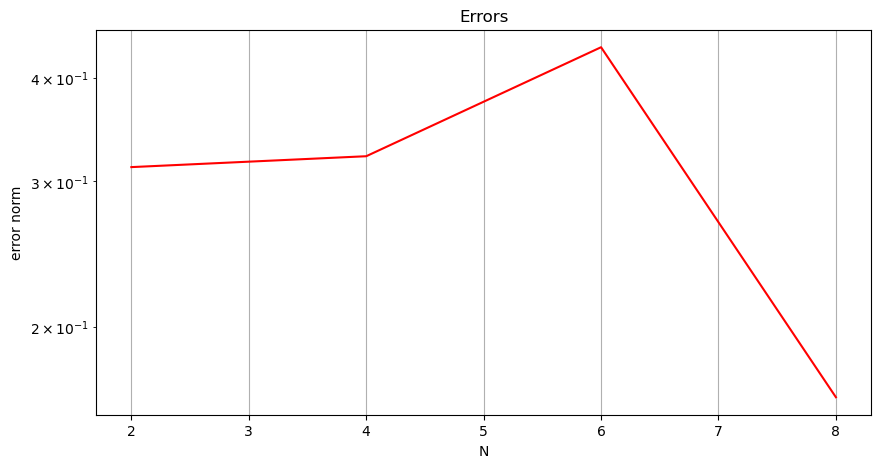

In [742]:
p = lambda x: (2 + x) / (3 + x)
p_derivative = lambda x: 1 / (3 + x) ** 2
q = lambda x: -p_derivative(x)
r = lambda x: 1 + sin(x)
f = lambda x: 1 - x
a = -1
right_part = 1
left_boundary_value = (0, -1, 0)
right_boundary_value = (1, 1, 0)

print("Results for Ritz method:")
run_test(a, right_part, p, q, r, f, left_boundary_value, right_boundary_value, ritz_method)

print("Results for Collacation method:")
run_test(a, right_part, lambda x: p(x), q, r, f, left_boundary_value, right_boundary_value, lambda p, q, r, f, lbv, rbv, n: collocation_method(lambda x: -p(x), q, r, f, lbv, rbv, n), high_n=10)